# ME 193 Project 3
## Computations in Python 
### Solving Kinematical Ordinary Differential Equations (ODEs)

An ordinary differential equation (ODE) is an equation that involves ordinary derivatives, as opposed to parital derivatives. The goal of setting up an ODE is to solve the set of derivatives and determine what function of functions satisfy the equation. The simplest possible ODE is as such: 
> Let *x(t)* be a function of *t* that satisfies the ODE: 
> > $\frac{dx}{dt}$ = 0

> This equation means that *x(t)* is a constant function, *x(t) = C*. There would be no way to specify the constant *C* unless it was given to us initially or with supporting data. Another generalized initial condition could be 

> > *x(t₀)= x₀*

> where *t₀* is some given time and *x₀* is some given number. So in this case we would initialize the system to be equal to the number *x₀* at the time *t = t₀*.

In my ME 121 Advanced Dynamics course, we are learning how to use Euler's rotation equations, which are first-order oridnary differential equations (ODEs), to describe the rotation of a rigid body by using a rotating reference frame with its axes fixed to the body. Euler's angles can be used to parameterize a rotation of a rigid body. 

We need a kinmematical ODE to solve for the equation to relate the Euler-angle derivatives to anuglar velocity expressed in a consistent basis. Any arbitrary orientation between two orthonormal-basis pairs can be described by 3 Euler angles, where each Euler angle is a rotation about the acis of an intermediate basis.

For this project I'll be demonstrating how to use kinematical ODEs to determine the Euler angles with given initial conidtions. We can solve for the Euler angles using rotation matrices and the forward Euler method to estimate how the angles change with time. We can then solve the problem about 200 times faster by using the odeint function in the scipy.integrate.ode class.

Consider a rigid body *D* and a reference frame *A* that could contain right-handed sets of orthogonal unit vectors $\hat{d_x}$, $\hat{d_y}$, $\hat{d_z}$ and $\hat{a_x}$, $\hat{a_y}$, $\hat{a_z}$, respectively. One way to characterize the general 3D orientation of $\hat{d_x}$, $\hat{d_y}$, $\hat{d_z}$ relative to $\hat{a_x}$, $\hat{a_y}$, $\hat{a_z}$ is with three Euler angles. Euler angles, also known as rotation angles or orientation angles, are one of many mathematical descriptions of orientation.

A *$\theta_1$*, *$\theta_2$*, *$\theta_3$* *Body xyz* rotation sequence first sets $\hat{d_i}$ = $\hat{a_i}$ (i = x, y, z) and then subjects *D* to succesive right-handed rotations characterized by *$\theta_1$*$\hat{d_x}$, *$\theta_2$*$\hat{d_y}$, *$\theta_3$*$\hat{d_z}$ (where *$\theta_1$*, *$\theta_2$*, *$\theta_3$* are angles).

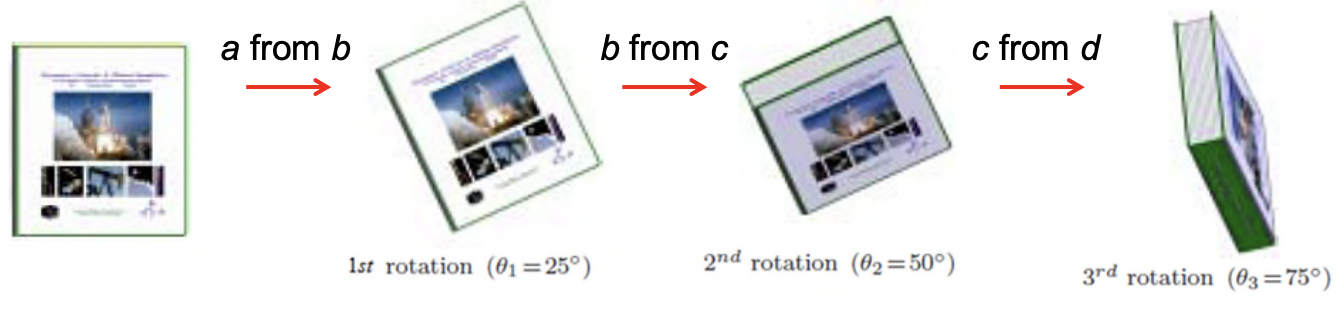

Successive matrix multiplication produces the rotation matrix/table $^aR^d$ relating $\hat{d_x}$, $\hat{d_y}$, $\hat{d_z}$ to $\hat{a_x}$, $\hat{a_y}$, $\hat{a_z}$.

In [1]:
import numpy as np
import math
import sympy as sym
from sympy import *
from numpy import matrix
from numpy import linalg
from sympy import MatrixSymbol, Matrix
from numpy.linalg import inv
from matplotlib import pyplot as plt
from scipy.integrate import odeint

t1 = sym.Symbol('t1')
t2 = sym.Symbol('t2')
t3 = sym.Symbol('t3')

c1 = sym.cos(t1)
c2 = sym.cos(t2)
c3 = sym.cos(t3)

s1 = sym.sin(t1)
s2 = sym.sin(t2)
s3 = sym.sin(t3)
    
x1=[1, 0, 0, 0, c1, -s1, 0, s1, c1]
x1=np.array(x1)
x1 = x1.reshape(3,3)
print(x1)

x2=[c2, 0, s2, 0, 1, 0, -s2, 0, c2]
x2=np.array(x2)
x2 = x2.reshape(3,3)
print(x2)

x3=[c3, -s3, 0, s3, c3, 0, 0, 0, 1]
x3=np.array(x3)
x3 = x3.reshape(3,3)
print(x3)

R=np.matmul(np.matmul(x1,x2), x3)
print(R)


[[1 0 0]
 [0 cos(t1) -sin(t1)]
 [0 sin(t1) cos(t1)]]
[[cos(t2) 0 sin(t2)]
 [0 1 0]
 [-sin(t2) 0 cos(t2)]]
[[cos(t3) -sin(t3) 0]
 [sin(t3) cos(t3) 0]
 [0 0 1]]
[[cos(t2)*cos(t3) -sin(t3)*cos(t2) sin(t2)]
 [sin(t1)*sin(t2)*cos(t3) + sin(t3)*cos(t1)
  -sin(t1)*sin(t2)*sin(t3) + cos(t1)*cos(t3) -sin(t1)*cos(t2)]
 [sin(t1)*sin(t3) - sin(t2)*cos(t1)*cos(t3)
  sin(t1)*cos(t3) + sin(t2)*sin(t3)*cos(t1) cos(t1)*cos(t2)]]


Now we can use this rotational matrix $^aR^d$ relating $\hat{d_x}$, $\hat{d_y}$, $\hat{d_z}$ to $\hat{a_x}$, $\hat{a_y}$, $\hat{a_z}$ to find the angular velocity. Angular velocity can be determined in terms of $\dot{\theta_1}$, $\dot{\theta_2}$, $\dot{\theta_3}$ and $\omega_x$, $\omega_y$, $\omega_z$. D's angular velocity in A can be written in two wats. First, we can use the angular velocity addition theorem to write ${^a\vec{\omega}^d}$ in terms of $\dot{\theta_1}$, $\dot{\theta_2}$, $\dot{\theta_3}$:
> ${^a\vec{\omega}^d}$ = $\dot{\theta_1}$$\hat{a_x}$ + $\dot{\theta_2}$$\hat{b_y}$ + $\dot{\theta_3}$$\hat{c_z}$

The expression above is written in mixed bases. But we can also define ${^a\vec{\omega}^d}$ in a body-fixed basis and relate $\omega_x$, $\omega_y$, $\omega_z$ and $\hat{d_x}$, $\hat{d_y}$, $\hat{d_z}$:

> ${^a\vec{\omega}^d}$ = $\omega_x$$\hat{d_x}$ + $\omega_y$$\hat{d_y}$ + $\omega_z$$\hat{d_z}$

We can now use the rotation matrix we calculated in the code above to find the angular velocity ${^a\vec{\omega}^d}$ in terms of $\dot{\theta_1}$, $\dot{\theta_2}$, $\dot{\theta_3}$ and $\hat{d_x}$, $\hat{d_y}$, $\hat{d_z}$.

In [2]:
wx = sym.Symbol('wx')
wy = sym.Symbol('wy')
wz = sym.Symbol('wz')

ax = np.array([R[0,0], R[0,1], R[0,2]])
by = np.array([s3, c3, 0])
cz = np.array([0, 0, 1])

w_ad = np.array([0,0,0,0,0,0,0,0,0], dtype=object)
w_ad = w_ad.reshape(3,3)


w_ad[0,0] = ax[0]
w_ad[0,1] = by[0]
w_ad[0,2] = cz[0]

w_ad[1,0] = ax[1]
w_ad[1,1] = by[1]
w_ad[1,2] = cz[1]

w_ad[2,0] = ax[2]
w_ad[2,1] = by[2]
w_ad[2,2] = cz[2]

w_ad=Matrix(w_ad)
Matrix(w_ad)

Matrix([
[ cos(t2)*cos(t3), sin(t3), 0],
[-sin(t3)*cos(t2), cos(t3), 0],
[         sin(t2),       0, 1]])

We can now write ODEs for $\dot{\theta_1}$, $\dot{\theta_2}$, $\dot{\theta_3}$. Dot-multiplication of the above expression with $\hat{d_x}$, $\hat{d_y}$, $\hat{d_z}$ gives us the matrix equation relating $\omega$ and $\dot{\theta}$. Inverting this relationship gives us the kinematical differential equations, and thus giving us our final matrix we can use to relate the Euler angles and angular velocity!

In [3]:
#Inverting matrix to get ODEs
w_ad.inv()

Matrix([
[         cos(t3)/(sin(t3)**2*cos(t2) + cos(t2)*cos(t3)**2),        -sin(t3)/(sin(t3)**2*cos(t2) + cos(t2)*cos(t3)**2), 0],
[                         sin(t3)/(sin(t3)**2 + cos(t3)**2),                         cos(t3)/(sin(t3)**2 + cos(t3)**2), 0],
[-sin(t2)*cos(t3)/(sin(t3)**2*cos(t2) + cos(t2)*cos(t3)**2), sin(t2)*sin(t3)/(sin(t3)**2*cos(t2) + cos(t2)*cos(t3)**2), 1]])

When we rearrange the matrix equations and simplify the inverse matrix we get the following systems of equations:
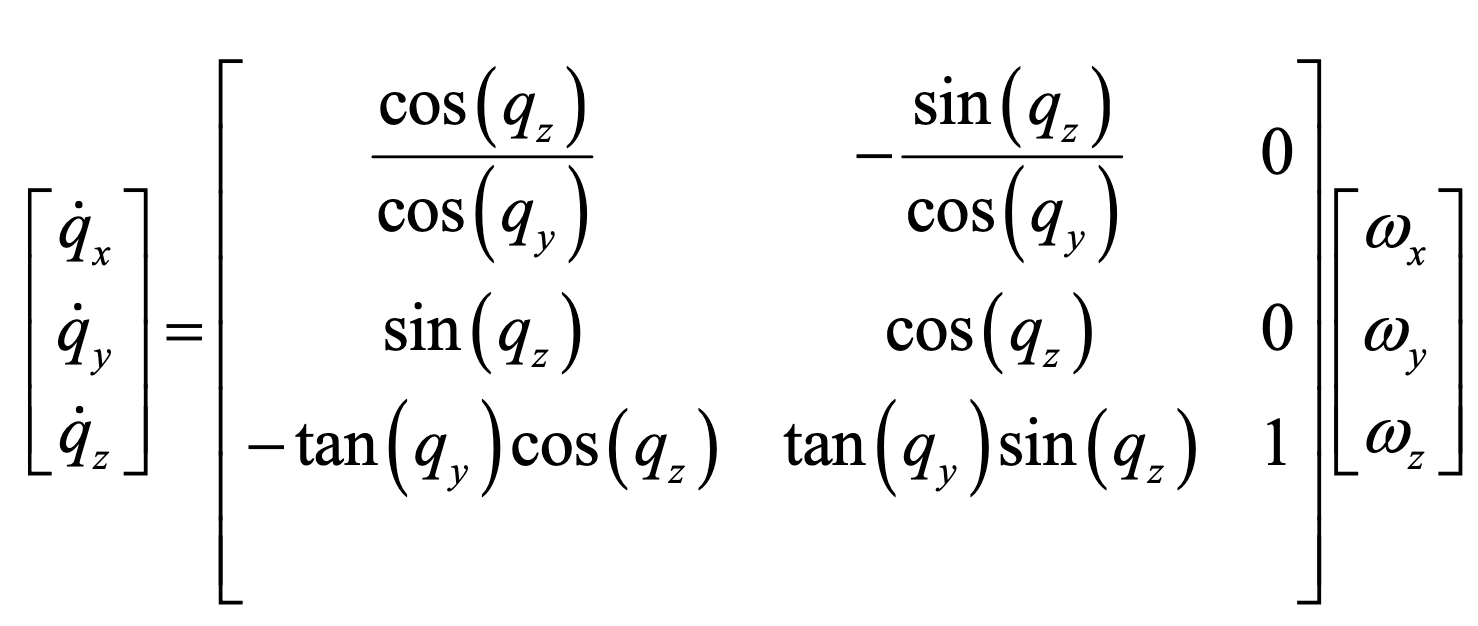

Let's now apply these equations to an actual example to see its implementation. We are given the following satellite that is rotated by the motors of a robotic arm at a constant angular velocity *D*. 
> ${^a\vec{\omega}^d}$ = $\omega_x$$\hat{d_x}$ + $\omega_y$$\hat{d_y}$ + $\omega_z$$\hat{d_z}$

where {$\omega_x$, $\omega_y$, $\omega_z$} = {*0.1, 0.2, 0.4*} $\sec^{-1}$

Our goal is to write a script that will plot the Euler angles over 15 seconds, assuming they are initially $q_x$ = $q_y$ = $q_z$ = 0 rad.
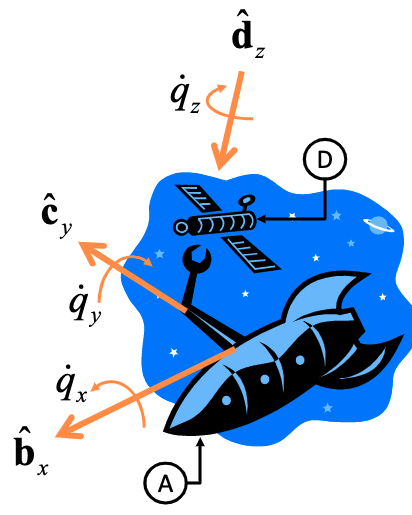

In [4]:
#This function takes in the body XYZ angles and converts them into one rotation matrix R
def rot_matrix(t1, t2, t3):
    c1 = math.cos(t1)
    c2 = math.cos(t2)
    c3 = math.cos(t3)

    s1 = math.sin(t1)
    s2 = math.sin(t2)
    s3 = math.sin(t3)
    
    #matrix for first rotation along the x-axis
    x=np.array([1, 0, 0, 0, c1, -s1, 0, s1, c1])
    x=x.reshape(3,3)
    
    #matrix for second rotation along the y-axis
    y=np.array([c2, 0, s2, 0, 1, 0, -s2, 0, c2])
    y=y.reshape(3,3)

    #matrix for third rotation along the z-axis
    z=np.array([c3, -s3, 0, s3, c3, 0, 0, 0, 1])
    z=z.reshape(3,3)
    
    #multiplying the three individual rotation matrices 
    R=np.matmul(np.matmul(x,y), z)
    return R

In [5]:
#This function takes in a rotation matrix and sets it up to solve the ODEs
def rot_matrixODE(R,t3):
    s3 = math.sin(t3)
    c3 = math.cos(t3)
    
    w_ad = np.array([R1[0,0],s3,0,R1[0,1],c3,0,R1[0,2],0,1])
    w_ad = w_ad.reshape(3,3)
    
    return Matrix(w_ad)

We will be using the **Forward Euler** method to differentiate the kinematical ODEs and find the Euler angles $q_x$, $q_y$, $q_z$.

The Forward Euler moethod approximates teh derivative with a difference quotient: 
> $\frac{dx}{dt}$ ≈ $\frac{y_{n+1} - y_n}{\Delta t}$

and simplifying that we get:

> $y_{n+1}$ = $y_n + f(t_n,y_n)\Delta t$

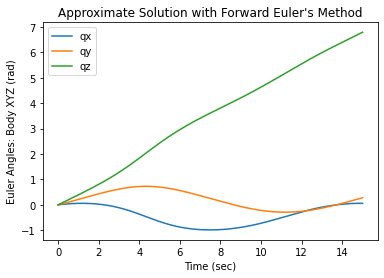

--- 30.583713054656982 seconds ---


In [6]:
#Our first goal is to make a loop where q1, q2, and q3 will be changing with time. We want to plot Euler
#angles over the first 15 seconds with initial condition that qx=qy=qz=0.
#Using forward Euler method to estimate our curves

import timeit
import time

#starting the timer
start_time=time.time()

if __name__ == "__main__":
    #given initial conditions for qx, qy, qz
    qx_o=0
    qy_o=0
    qz_o=0
    
    #setting up our delta t and our t vector for integration
    to=0
    tf=15
    n=10001
    del_t=(tf-to)/(n-1)
    t=np.linspace(to,tf,n)
    
    #initializing the qx, qy, qz vectors
    qx=np.zeros([n])
    qy=np.zeros([n])
    qz=np.zeros([n])

    qx[0]=qx_o
    qy[0]=qy_o
    qz[0]=qz_o
    
    #given constant angular velocity D
    om=np.array([0.1, 0.2, 0.4]) #rad/sec
    om=om.reshape(3,1)
    
    #calling the functions to get our ODE matrix
    R1=rot_matrix(qx[0], qy[0], qz[0])
    w=rot_matrixODE(R1,qz[0])

#for loop that solves the ODEs by integrating dq/dt over the specified delta t
for i in range(1,n):
    #solving for dq/dt by calculating the dot product
    qdot=np.matmul(w.inv(),om)
    
    qx[i]=del_t*(qdot[0])+qx[i-1]
    qy[i]=del_t*(qdot[1])+qy[i-1]
    qz[i]=del_t*(qdot[2])+qz[i-1]
    
    R1=rot_matrix(qx[i], qy[i], qz[i])
    w=rot_matrixODE(R1,qz[i])

#plotting the Euler angles over 15 seconds
plt.plot(t,qx,label="qx")
plt.plot(t,qy,label="qy")
plt.plot(t,qz,label="qz")
plt.legend(loc="upper left")
plt.xlabel("Time (sec)")
plt.ylabel("Euler Angles: Body XYZ (rad)")
plt.title("Approximate Solution with Forward Euler's Method")
plt.show()

#time to execute the code
print("--- %s seconds ---" % (time.time() - start_time))

So python is nifty and can actually solve differential equations. We can use the Scipy.integrate package and use function **odeint**. **odeint** requires three inputs:
> *y = odeint(model, y0, t)*

1. **model**: function name that returns derivative values at requested y and t values as dydt = model(y,t)
2. **y0**: initial conditions of the differential states
3. **t**: time points at which the solution should be reported. Additional internal points are often calculated to maintain accuracy of the solution but are not reported.

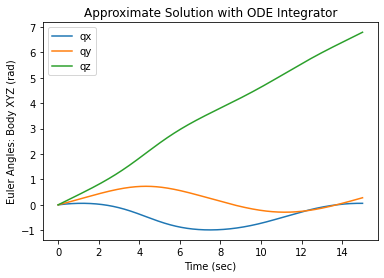

--- 0.18382620811462402 seconds ---


In [7]:
#solving our differential equation by creating an ode function that takes the initial conditions and uses the 
#inverse rotation matrix to compute dq/dt
def ode_func(qdot,t):
    qx=qdot[0]
    qy=qdot[1]
    qz=qdot[2]
    
    #given constant angular velocity D
    om=np.array([0.1, 0.2, 0.4]) #rad/s
    
    #simplified rotation matrix in terms of qx, qy, qz
    A=np.array([math.cos(qz)/math.cos(qy), -math.sin(qz)/math.cos(qy), 0
        , math.sin(qz), math.cos(qz), 0
        ,-math.tan(qy)*math.cos(qz), math.tan(qy)*math.sin(qz), 1])
    A=A.reshape(3,3)
    
    #solving for dq/dt by calculating the dot product  
    qdot=np.matmul(A,om)
    return qdot

#starting the timer
start_time=time.time()
if __name__ == "__main__":
    
    #given initial conditions for qx, qy, qz
    qo=([0, 0, 0])    
    
    #setting up our time vector for the odeint function
    to=0
    tf=15
    n=10001
    t=np.linspace(to,tf,n)
    
    #using the odeint function to integrate qdot over the specified time t
    #returns Euler angles in one output vector
    qdot=odeint(ode_func,qo,t)

#plotting the Euler angles over 15 seconds
plt.plot(t,qdot[:,0],label="qx")
plt.plot(t,qdot[:,1],label="qy")
plt.plot(t,qdot[:,2],label="qz")
plt.legend(loc="upper left")
plt.xlabel("Time (sec)")
plt.ylabel("Euler Angles: Body XYZ (rad)")
plt.title("Approximate Solution with ODE Integrator")
plt.show()

#time to execute the code
print("--- %s seconds ---" % (time.time() - start_time))

Woooot, using python's handy-dandy **odeint** function, we get our solution ~180 times faster! The fastest I got it to work was 201 times, but who's counting really.